In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import os
import math
import metpy
import datetime
import matplotlib.pyplot as plt 
import scipy.stats as sstats
from scipy.stats.sampling import DiscreteAliasUrn
from matplotlib import cm
import random
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import IPython.display
import json
import sys
import yaml
from random import randrange
import metpy.calc as mpcalc
from metpy.units import units
from functions_gapfill import *
import gstools as gs
import statsmodels.api as sm

# Gapfilling the AWS of the LéXPLORE platform

In this notebook we use the G2S server with Direct Sampling approach (https://gaia-unil.github.io/G2S/briefOverview.html) to fill the data gaps of the meteo station or AWS of the LéXPLORE platform (https://gitlab.renkulab.io/lexplore).

See other notebooks in this repository on how to arrive at this point. 

We use already 1 hourly aggregated values of the meteo station and we fill gaps for the following variables on 1 hour resolution:

* Air temperature

* Baromatric pressure 

* Relative Humidity

* Wind Speed

* Wind Direction

* Wind Gusts (PROBABLY NOT)

* Precipitation

* Solar Incoming Radiation 

* Solar Total Incoming Radation (PROBABLY NOT)

To do so, we use independent data as co-variates, namely variables from the closest gridpoint in ERA5 and ERA5-land. Other potential co-variates could be AWS data from other locations around Lake Geneva or data from other weather models or reconstructions. 

## Activate G2S server

In [3]:
#!pip install G2S libtiff --quiet
from g2s import g2s
g2s('--version')


G2S version 0.98.015, compiled the Dec 17 2022 16:39:25 with Python 3.11.1


In [4]:
#! git clone https://github.com/GAIA-UNIL/G2S.git --quiet

In [5]:
#%%capture
#!export NVFLAGS='-gencode=arch=compute_35,code=sm_35 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_52,code=sm_52 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_70,code=compute_70'
#!sudo apt -qq install build-essential libzmq3-dev libjsoncpp-dev zlib1g-dev libfftw3-dev libcurl4-openssl-dev -y
#!sudo wget -q "https://raw.githubusercontent.com/zeromq/cppzmq/master/zmq.hpp" -O /usr/include/zmq.hpp
#!( cd G2S/build && make c++ -j --silent)
#!bash G2S/build/c++-build/install_needs_W_VM.sh

In [6]:
!pwd

/home/mwegmann/g2s/notebooks


In [7]:
os.chdir("/home/mwegmann/g2s")

In [8]:
!bash -c "cd G2S/build/c++-build/ && ./server -d"


start daemon


In [9]:
ti = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/stone.tiff').content)));

In [10]:
a=g2s('-a','echo','-ti',ti,'-dt',[0])

job Id is: 490207181
progress 100.000%      
        

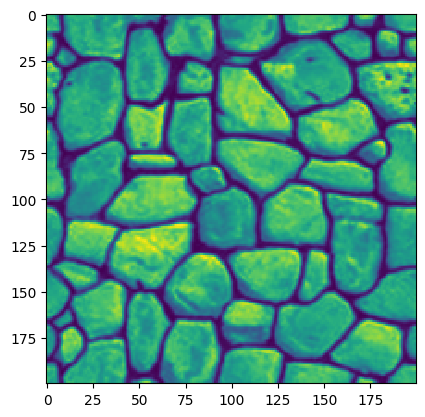

In [11]:
plt.imshow(a[0], interpolation='nearest')

## folder setup

In [12]:
# change yaml location here
with open(r"/home/mwegmann/g2s/notebooks/folder_gap_filling.yaml", "r") as f:
    directories = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
#for d in directories.values():
#    if not os.path.exists(d):
#        os.makedirs(d)

In [14]:
# defining folders
input_folder=directories["g2s_input_folder"]

output_folder=directories["g2s_output_folder"]

scripts_folder=directories["scripts_folder"]

## read in data

In [15]:
ms_pully=xr.open_dataset(input_folder+"ms_pully_1hr_g2s.nc")

In [16]:
ms_pully

<xarray.Dataset>
Dimensions:  (time: 26280)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    rad      (time) float64 ...
    sp       (time) float64 ...
    t2m      (time) float64 ...
    precip   (time) float64 ...
    rh       (time) float64 ...
    sun      (time) float64 ...
    ws       (time) float64 ...
    wd       (time) float64 ...
Attributes:
    description:  For metadata see jupyter notebook get_ms_data_for_gapfill

In [17]:
cosmo=xr.open_dataset(input_folder+"cosmo_1hr_g2s.nc")

In [18]:
cosmo

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    T_2M       (time) float64 ...
    RELHUM_2M  (time) float64 ...
    TOT_PREC   (time) float64 ...
    PS         (time) float64 ...
    GLOB       (time) float64 ...
    CLCT       (time) float64 ...
    U          (time) float64 ...
    V          (time) float64 ...

In [19]:
cosmo_ws=mpcalc.wind_speed(cosmo["U"]* units("m/s"),cosmo["V"]* units("m/s"))
cosmo_ws.name="WS"

In [20]:
cosmo_wd=mpcalc.wind_direction(cosmo["U"]* units("m/s"),cosmo["V"]* units("m/s"))
cosmo_wd.name="WD"

In [21]:
cosmo=xr.merge([cosmo_ws,cosmo_wd,cosmo])

In [22]:
meteo_orig=xr.open_dataset(input_folder+"meteo_1hr_g2s.nc")

In [23]:
meteo_orig

<xarray.Dataset>
Dimensions:   (time: 26280)
Coordinates:
  * time      (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC     (time) float64 ...
    RH        (time) float64 ...
    Slrw      (time) float64 ...
    WS        (time) float64 ...
    WindDir   (time) float64 ...
    Rain      (time) float64 ...
    BP        (time) float64 ...
    WindGust  (time) float64 ...

In [24]:
era5=xr.open_dataset(input_folder+"era5_lexplore_g2s.nc")

In [25]:
era5

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    t2m        (time) float32 ...
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    tp         (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-05 18:55:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [26]:
era5_ws=mpcalc.wind_speed(era5.u10,era5.v10)
era5_ws.name="ws"

In [27]:
era5_wd=mpcalc.wind_direction(era5.u10,era5.v10)
era5_wd.name="wd"

In [28]:
era5=xr.merge([era5_ws,era5_wd,era5])

In [29]:
era5_land=xr.open_dataset(input_folder+"era5_land_lexplore_g2s.nc")

In [30]:
era5_land_ws=mpcalc.wind_speed(era5_land.u10,era5_land.v10)
era5_land_ws.name="ws"

In [31]:
era5_land_wd=mpcalc.wind_direction(era5_land.u10,era5_land.v10)
era5_land_wd.name="wd"

In [32]:
era5_land=xr.merge([era5_land_ws,era5_land_wd,era5_land])

In [33]:
#cosmo_rea

## define L3 boundaries

In [34]:
time_resolution_hr=1

In [35]:
timestepsinday=24/time_resolution_hr

In [36]:
max_day_gap=5

In [37]:
max_timesteps_tofill=time_resolution_hr*max_day_gap

## Fill Air Temperature Data

### understand the average gap size in data

In [38]:
varname="AirTC"


In [ ]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_airtc",plot_folder=output_folder)

### Run gapfilling

The idea is to create gaps that are always at the same position, but different in size.


It is tricky to think about a "perfect gap size" that we should try out. I would suggest that we try out gap sizes from 1 day (24 missing values in the case of the meteo station) towards 4 days (96 missing values in case of the meteo station).

The other question is how many (in %) new missing values do we introduce to evaluate our routine. The meteo station has 3% missing data as it is. Is 10% a good metric to evaluate? 20%?

We have three steps for the reconstruction of each variable:

* Covariate evaluation with N=25, 5% missing data, and [24,48,72] gaps and 10 test runs

* Creating error matrix for error propagation analysis with preferred covariate with N=25, [5,10,15,20] missing data, and [24,48,72,96] gaps and 5 test runs

* Creating the final product/reconstruction with N=50

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="t2m",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="t2m",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="T_2M",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")


In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["t2m"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["t2m"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L3.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L4.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Air Pressure Data

### understand the average gap size in data

In [ ]:
varname="BP"


In [ ]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_bp",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="sp",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="sp",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="PS",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")


In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["sp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["sp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L3.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L4.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Incoming Solar Radiation Data

### understand the average gap size in data

In [ ]:
varname="Slrw"


In [ ]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_slrw",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="ssrd",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="ssrd",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="GLOB",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")


In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ssrd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ssrd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L3.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L4.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Rainfall Data

### understand the average gap size in data

In [39]:
varname="Rain"


meteo_orig_rain has 929 nans in 26280 data points
meteo_orig_rain has 3.54% missing values
meteo_orig_rain has 72 gaps with 1.0 median gap size
meteo_orig_rain has 72 gaps with 12.9 mean gap size


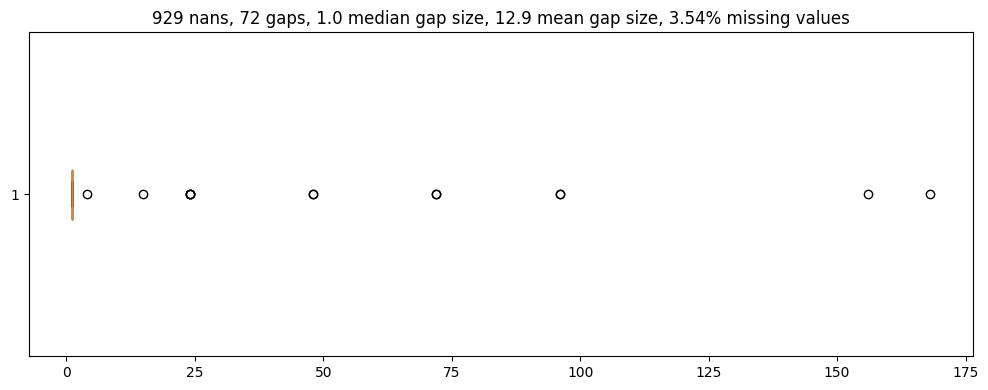

In [40]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_rain",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="precip",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="tp",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:

filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="tp",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [41]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [42]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

,RUN,MEMBER,PERC,CORR,CORR_lin,CORR_akima,CORR_spline,CORR_quad,CORR_pchip,CORR_subdlin,RMSE,RMSE_lin,RMSE_akima,RMSE_spline,RMSE_quad,RMSE_pchip,RMSE_subdlin,STDR
GAP_SIZE,,,,,,,,,,,,,,,,,,
24,5.5,25.0,5.0,0.92742,0.93346,0.93300,0.93475,0.89111,0.93333,0.92309,0.04781,0.03876,0.03975,0.03545,0.08165,0.03912,0.04761,-1.985648e+07
48,5.5,25.0,5.0,0.91705,0.92838,0.92805,0.92916,0.79700,0.92846,0.92735,0.05861,0.03934,0.04009,0.03807,0.13399,0.03933,0.04173,-1.731031e+06
72,5.5,25.0,5.0,0.92727,0.93412,0.92501,0.93471,0.86555,0.93402,0.93369,0.04686,0.03736,0.04918,0.03567,0.09982,0.03760,0.03833,-2.257874e+05


In [43]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

,RUN,MEMBER,PERC,CORR,CORR_lin,CORR_akima,CORR_spline,CORR_quad,CORR_pchip,CORR_subdlin,RMSE,RMSE_lin,RMSE_akima,RMSE_spline,RMSE_quad,RMSE_pchip,RMSE_subdlin,STDR
GAP_SIZE,,,,,,,,,,,,,,,,,,
24,5.5,25.0,5.0,0.99231,0.99563,0.99514,0.99616,0.95808,0.99560,0.98547,0.02452,0.01840,0.01966,0.01659,0.06425,0.01841,0.02929,-91092.82026
48,5.5,25.0,5.0,0.92661,0.93617,0.93419,0.93691,0.85807,0.93612,0.93477,0.04776,0.03452,0.03870,0.03265,0.10205,0.03456,0.03724,-42965.48357
72,5.5,25.0,5.0,0.99712,0.99696,0.99249,0.99800,0.80941,0.99700,0.99573,0.01668,0.01675,0.02289,0.01381,0.16399,0.01649,0.01957,-27177.12419


In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_cosmo_",vario=True)

In [44]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [45]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_cosmo_",vario=True)

Amount NAs in orig :929
% NAs in orig :3.5350076103500756
Amount NAs in new :3569
% NAs in new :13.580669710806697
Added % NAs :10.045662100456621
This is run 1 with N=25 added missing % is 10 and Gap size is 24
job Id is: 1589003629
progress 100.000%       
        job Id is: 1162156144
progress 100.000%       
        job Id is: 88196489
progress 100.000%       
        job Id is: 3932789993
progress 100.000%       
        job Id is: 3467710310
progress 100.000%       
        job Id is: 2383049678
progress 100.000%       
        job Id is: 3164669402
progress 100.000%       
        job Id is: 3320477454
progress 100.000%       
        job Id is: 3504999906
progress 100.000%       
        job Id is: 3673149228
progress 100.000%       
        job Id is: 3848982137
progress 100.000%       
        job Id is: 3392661116
progress 100.000%       
        job Id is: 3564847811
progress 100.000%       
        job Id is: 3751572564
progress 100.000%       
        job Id is: 393093650

In [46]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_cosmo_",vario=True)

Amount NAs in orig :929
% NAs in orig :3.5350076103500756
Amount NAs in new :4865
% NAs in new :18.512176560121766
Added % NAs :14.977168949771688
This is run 1 with N=25 added missing % is 15 and Gap size is 24
job Id is: 1344281179
progress 100.000%       
        job Id is: 2739493441
progress 100.000%       
        job Id is: 4155169428
progress 100.000%       
        job Id is: 1259487489
progress 100.000%       
        job Id is: 2650269164
progress 100.000%       
        job Id is: 4049205457
progress 100.000%       
        job Id is: 1163179756
progress 100.000%       
        job Id is: 2557786746
progress 100.000%       
        job Id is: 3956838192
progress 100.000%       
        job Id is: 1062657557
progress 100.000%       
        job Id is: 2456532093
progress 100.000%       
        job Id is: 3858550398
progress 100.000%       
        job Id is: 963689883
progress 100.000%       
        job Id is: 2363667558
progress 100.000%       
        job Id is: 37643288

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["tp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["tp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L3.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L4.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Wind Direction Data

### understand the average gap size in data

In [ ]:
varname="WindDir"

In [ ]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_winddir",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="wd",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="wd",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="WD",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["wd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["wd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L3.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L4.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Wind Speed Data

### understand the average gap size in data

In [ ]:
varname="WS"

In [ ]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_ws",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="ws",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="ws",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="WS",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ws"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ws"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L3.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L4.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Relative Humidity Data

### understand the average gap size in data

In [ ]:
varname="RH"

In [ ]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_rh",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=two_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2=["t2m","tp"],cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=two_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2=["t2m","tp"],cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="RELHUM_2M",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["rh"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["rh"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L3.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_"+varname+"_ms_pully_50member_L4.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)